<a href="https://colab.research.google.com/github/NinelK/IMBIZO2023_population_tutorial/blob/main/Part3_bonus_nonlinear_dynamic_SOLUTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bonus: Nonlinear dynamical systems

## Setups

In [ ]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets       # interactive display
from matplotlib import rcParams
from scipy.linalg import expm
from scipy.optimize import minimize
rcParams.update({'font.size': 18})

### Dimensionality reduction on Hodgkin-Huxley model

Yesterday you have run simulations of a biophysically accurate neuron models with a Hodgkin-Huxley equation (HH). To recap, the set of HH equations contained the following 4 equations:

$$ C \frac{dV}{dt} = -\bar g_K n^4 (V - V_K) - \bar g_{Na} m^3 h(V-V_{Na}) - \bar g_l (V - V_l) + I_{ext}\tag{4a} $$

<br>

\begin{align}
\frac{dn}{dt} &= \alpha_n(V)(1-n) - \beta_n(V) n\tag{4b} \\
\frac{dm}{dt} &= \alpha_m(V)(1-m) - \beta_m(V) m\tag{4c} \\
\frac{dh}{dt} &= \alpha_h(V)(1-h) - \beta_h(V) h\tag{4d}
\end{align}

The state space of this model is 4D, which is too much for visualization and analyse.
However, not all equations here are equally important.

<p align='center'><img src='https://raw.githubusercontent.com/NinelK/IMBIZO2023_population_tutorial/main/figures/hh_gates.jpg?raw=True'/></p>


**Fig. 1a**  The equilibrium functions for the three variables $m, n, h$ | **Fig. 1b** The voltage dependent time constants

#### Step 1. Time scale separation between fast ($V$) and very-fast ($m$) variables

  First, we can look at the timescales of different equations (Fig. 1a).  We see that sodium channel activation $m$ changes much faster than other gating variables, faster than a single spike ($<$1ms).
Therefore, we can assume that equation (4c) always quickly reaches equilibrium $dm/dt=0$, and substitute eq. (4c) with a *quasi-steady state* approximation $m(t) = m_0(V(t))$. Thus, we get rid of a differential equation (4c).

#### Step 2. Merging two similar slow equations ($n$ and $h$)

  From Fig.1a we also see that both sodium channel inactivation $h$ and potassium channel gating $n$ change slowly (on a scale of 5-10ms). We can also notice that in Fig.1b $n(V)$ looks roughly like $1-h(V)$ (not exactly, but it is an approximation).
So, since these two variables have similar dependencies on both time and voltage, we can substitute them with a single variable $w$ that approximates both gating variables. Thus, we merge eq. (4b) and (4d) into one. 

#### Result: 2D FitzHugh-Nagumo (FHN) model

Following 2 steps above, we merged 2 **fast** equations and 2 **slow** equations, which results in the following model:

\begin{align}
\mathrm{\mathbf{Fast:}} \quad\frac{dV}{dt} &= V(1-V)(V-V_{thr}) - w + i_{ext} \tag{5a}\\
\mathrm{\mathbf{Slow:}} ~\quad \frac{dw}{dt} &= \epsilon (\beta V - w) \tag{5b}
\end{align}

here some coefficients like time constants and capacitance of the membrane are typically omitted for simplicity.

The two equations are also often called **fast activator** and **slow inhibitor**. Because the first equation describes cell's depolarization and sodium channel opening (activation), while the second equation describes everything that works towards repolarization (potassium currents + sodium channels' inactivation).
The parameter responsible for fast/slow timescales separation is $\epsilon$, which is typically set to $0.01$ (i.e. 5b is 100x slower than 5a).

Now that we have a 2D system, we can visualize its phase portrait!

### Phase portrait of FHN

In [ ]:
# Plotting phase portraits
def plot_FHN_phase_portrait(i_ext,V_thr,beta,
                            V_null = None, w_null = None,
                            V_min = -.5, V_max = 1.2,
                            w_min = -.1, w_max = .2,
                            eps=0.01,n=30):
    '''
    Plots a phase portrait for a FitzHugh-Nagumo model (eq. 5)
    n: number of points in the n x n grid
    '''
    plt.figure(figsize=(5,5))
    V_grid = np.linspace(V_min,V_max, n) # a 1D activator grid
    w_grid = np.linspace(w_min,w_max, n) # a 1D inhibitor grid
    x = np.array(np.meshgrid(V_grid, w_grid)).reshape((2,-1)) # a 2D flattened grid
    V, w = x
    V_dot = V*(1-V)*(V-V_thr) - w + i_ext #2remove
    w_dot = eps*(beta * V - w) #2remove
    plt.streamplot(V_grid,w_grid,V_dot.reshape(n,n),w_dot.reshape(n,n),
                 color=np.linalg.norm(np.array([V_dot,w_dot]),axis=0).reshape(n,n),
                 cmap='coolwarm',density=1.5)
    if V_null is not None:
        plt.plot(V_grid,V_null(V_grid,V_thr,i_ext),c='k')
    if w_null is not None:
        plt.plot(V_grid,w_null(V_grid,beta),c='k')
    plt.xlabel('fast activator V')
    plt.ylabel('slow inhibitor w')
    plt.xlim([V_min,V_max])
    plt.ylim([w_min,w_max])
    plt.clim(vmin=0,vmax=.2)

@widgets.interact
def interactive_FHN_portrait(i_ext=widgets.FloatSlider(min=-.2, max=.3, value=0), 
                            V_thr=widgets.FloatSlider(min=0, max=1, value=0.2),
                            beta=widgets.FloatSlider(min=0.05, max=.5, value=.4),):
    plot_FHN_phase_portrait(i_ext,V_thr,beta)

interactive(children=(FloatSlider(value=0.0, description='i_ext', max=0.3, min=-0.2), FloatSlider(value=0.2, d…

Looks very complicated! Although, if we look at some parts of the phase plane, locally it might resemble some of the patterns of an LDS behavior that we have seen before. (by the way, which ones?)

### Fixed points, nullclines, stability

While linear systems had just one fixed point, non-linear systems can have many. Moreover, even the number of fixed points can change depending on the parameters (like $V_{thr}$ or $\gamma$) 🤯

We can find fixed points, by dealing with equations (5a) and (5b) one by one. The set of points where $\dot V = 0$ is called **$V$-nullcline**. Nullclines divide the phase plane into two parts, based on the sign on the derivative. 

Let us add the nullclines to the phase portrait. We will define them as functions + learn an additional way to define single-expression functions in python: 

In [ ]:
V_nullcline = None
w_nullcline = None
@widgets.interact
def interactive_FHN_portrait(i_ext=widgets.FloatSlider(min=-.2, max=.3, value=0,step=.01), 
                            V_thr=widgets.FloatSlider(min=0, max=1, value=0.2),
                            beta=widgets.FloatSlider(min=0.05, max=.5, value=.4, step=0.01),):

    global V_nullcline, w_nullcline

    # There are two ways to define functions in python.
    # 1. def name(args): (function)
    #       ... some computations
    #       return output
    # 2. name = lambda args: output (a lambda-function: 1) has one expression for outputs; 2) does not have to have a name)

    # write equations for nullclines as a function of V: lambda-way
    V_nullcline = lambda V, V_thr, i_ext: V*(1-V)*(V-V_thr)+i_ext   #2remove
    w_nullcline = lambda V, beta: V*beta                            #2remove

    # write equations for nullclines as a function of V: standard-way
    def V_nullcline(V, V_thr, i_ext):
        return V*(1-V)*(V-V_thr)+i_ext   #2remove
    def w_nullcline(V, beta):
        return V*beta                            #2remove

    plot_FHN_phase_portrait(i_ext,V_thr,beta,
                          V_null = V_nullcline, w_null = w_nullcline)

interactive(children=(FloatSlider(value=0.0, description='i_ext', max=0.3, min=-0.2, step=0.01), FloatSlider(v…

#### Exercise 5: FHN fixed points
What is the minimal and maximal number of fixed points we can get?

**Solution:** minimal 1, maximal 3

### Analysing stability


#### Local stability


Suppose the nullclines are intersecting somewhere in the middle, like this:

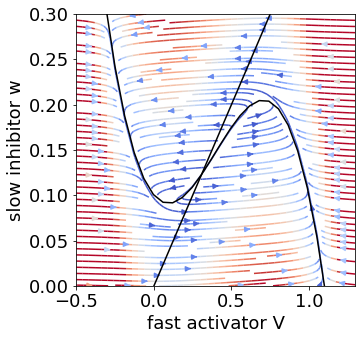

In [ ]:
i_ext, V_thr, beta = 0.1, 0.2, 0.4
plot_FHN_phase_portrait(i_ext,V_thr,beta,
                        V_max=1.3, w_min=0, w_max=.3,
                        V_null = V_nullcline, w_null = w_nullcline)

We see that globally, in the whole phase plane, the arrows that indicate the derivative $\mathbf{\dot x} = [\dot V, \dot w]^T$ change their directions in non-trivial ways, because $\mathbf{\dot x} = F(\mathbf{x})$ is non-linear. 

However, we can locally **linearize** the dynamical system:  approximate the the evolution operator $F(.)$ with a linear function:

$$\mathbf{\dot x} = F(\mathbf{x}) \approx \left.\frac{\partial \mathbf{F}}{\partial \mathbf{x}}\right |_{x_0} \mathbf{x} = 
\begin{bmatrix}
    \frac{\partial F_V}{\partial V} & \frac{\partial F_V}{\partial w}\\
    \frac{\partial F_w}{\partial V} & \frac{\partial F_w}{\partial w}
\end{bmatrix}_{\mathbf{x}_0}  \mathbf{x} + \mathbf{b}$$

If we linearize about a randomly picked point on the phase plane, we'll get an additional non-zero term $\mathbf{b}$.

But if $x_0$ is a fixed point, then:

$$ \mathbf{\dot x} = \mathbf{\dot{(x - x_0)}} = 
\begin{bmatrix}
    \frac{\partial F_V}{\partial V} & \frac{\partial F_V}{\partial w}\\
    \frac{\partial F_w}{\partial V} & \frac{\partial F_w}{\partial w}
\end{bmatrix}_{\mathbf{x}_0}  (\mathbf{x} -\mathbf{x_0}) $$

because for $\mathbf{x} =\mathbf{x_0}$ the derivative must be zero. This can be rewritten simply as:

$$ \mathbf{\dot{\hat x}}= \mathrm{J} \mathbf{\hat x} $$

This matrix $\mathrm{J}$ is called a **Jacobian** (scary name!). But it only has 4 components, which we can derive analytically (with pen and paper) from eq. 5a-5b:

In [ ]:
def find_nullcline_intersection(V_thr,i_ext,beta):
    diff = lambda x: np.abs(V_nullcline(x,V_thr,i_ext) - w_nullcline(x,beta))
    return minimize(diff,0.4).x[0]


eps = 0.01
V = find_nullcline_intersection(V_thr,i_ext,beta)
print(f'Nullclines intersect at V={V:.3f}')
J = np.array([[(1-V)*(V-V_thr)+i_ext, -1],
              [eps*beta, -eps]])               #2remove

print("Eigenvalues of a Jacobian: ",np.linalg.eig(J)[0])

Nullclines intersect at V=0.307
Eigenvalues of a Jacobian:  [0.14882255 0.01518534]


#### **Think!**
So, is it stable?

**Answer:** No. The eigenvalues are positive, so the solution is repulsed from the fixed point.

#### Global stability

Now let us take a step back. Literally. Let us zoom out on that phase portrait:

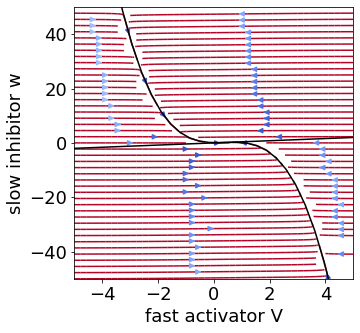

In [ ]:
i_ext, V_thr, beta = 0.1, 0.2, 0.4
plot_FHN_phase_portrait(i_ext,V_thr,beta, eps=.1,
                        V_min=-5, V_max=5, w_min=-50, w_max=50,
                        V_null = V_nullcline, w_null = w_nullcline)

##### **Think!**
We see that all of the arrows are point towards the cubic V-nullcline. But why are they horizontal? *(click for answer)*


**Answer:** Because of timescale separation, eps << 1. The rate of change of the state is much higher in horizontal direction than in vertical.

After they reach the cubic V-nulcline, V does not change anymore, but $ dw/dt \sim -w$ for large $w$. So, overall, the system is attracter towards (0,0) on a global scale.

#### **Summarize and Think!**

What should happen on intermediate timescale if:
1. **locally**: two nullclines have only one intersection which is a *repeller*
2. **globally** the states are *attracted* towards (0,0)

?


**Answer:** Since there are no other stable fixed points, the state can not stop changing. It is repelled both from the unstable fixed point and from the infinity... so it must then orbit around the unstable point! 🪐

### Visualizing trajectories

With all the knowledge you possess now, you can figure out all possible behaviors of this system with only pen and paper. But it is a lot of work! Instead, we can take a fun route and visulize some trajectories starting from random initial conditions:

In [ ]:
def plot_FHN_trajectories(i_ext,V_thr,beta,
                          N=10, T=20000, dt=.1,eps=0.01,n=30):
    '''
    Plots a trajectories for a FitzHugh-Nagumo model (eq. 5)
    '''
    fig, ax = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios': [1,2]})

    # plot trajectories
    V_dot = lambda V, w: V*(1-V)*(V-V_thr) - w + i_ext #2remove
    w_dot = lambda V, w: eps*(beta * V - w) #2remove
    # generate some initial conditions
    V_0 = np.random.randn(N) * .5 + 0.5
    w_0 = np.random.randn(N) * .02 + .05
    # create an empty array for storing solutions 
    traject = np.empty((2,T+1,N))
    traject[:,0] = np.array([V_0, w_0])
    for t in range(T):
        traject[:,t+1] = np.clip(
                          [traject[0,t] + V_dot(*traject[:,t])*dt,
                          traject[1,t] + w_dot(*traject[:,t])*dt],-10,10)
    for i in range(N):
        ax[0].plot(*traject[...,i],alpha=.3,linewidth=5)
        ax[1].plot(traject[0,:,i])

    # plot nullclines
    global V_nullcline, w_nullcline
    V_grid = np.linspace(-.5, 1.2, n) # a 1D activator grid
    ax[0].plot(V_grid,V_nullcline(V_grid,V_thr,i_ext),c='k')
    ax[0].plot(V_grid,w_nullcline(V_grid,beta),c='k')

    ax[0].set_xlabel('fast activator V')
    ax[0].set_ylabel('slow inhibitor w')
    ax[1].set_ylabel('fast activator V')
    ax[1].set_xlabel('time')
    ax[0].set_xlim([-.5,1.2])
    ax[1].set_ylim([-.5,1.2])
    ax[0].set_ylim([-.1,.2])

@widgets.interact
def interactive_FHN_trajectories(i_ext=widgets.FloatSlider(min=-.2, max=.3, value=0,step=.01), 
                            V_thr=widgets.FloatSlider(min=0, max=1, value=0.2),
                            beta=widgets.FloatSlider(min=0.05, max=.5, value=.25, step=.01),):
    plot_FHN_trajectories(i_ext,V_thr,beta)

interactive(children=(FloatSlider(value=0.0, description='i_ext', max=0.3, min=-0.2, step=0.01), FloatSlider(v…

Yay, we've got action potentials!

Not particularly beautiful action potentials (well, it is an approximated, reduced model), but still action potentials!

If you don't see anything like action potentials, try stimulating the FHN neuron just a little bit with the external current $i_{ext}$. It makes sense, right? The neuron responds to some inputs.



### **Think: linear vs nonlinear oscillations**

Now that you've seen a linear oscillator and a non-linear oscillator (limit cycle), what is the key qualitative difference between them? How would the amplitude of oscillations change if you change initial conditions?

**Solution:** Non-linear oscillator has a roughly fixed amplitude regardless of the initial conditions, while the amplitude of linear oscillator linearly depends on initial conditions (in other words, the further you swing the pendulum, the larger the amplitude will be).

In biology, many things have fixed amplitudes. For instance, action potential stays within a certain limit of voltages (e.g. -80 to +20 mV). A limit cycle model explains this behavior. In neuroscience, limit cycles can be found in central pattern generator (CPT) literature.

## Summary

In this bonus part of the tutorial, we:
1. Learned that nonlinear systems can have not just *one* but *many* fixed points
2. Learned how to linearize the dynamical system about a fixed point and check its local stability
3. Learned a new type of an attractor: a limit cycle!
4. Simulated some action potentials!